In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications.resnet50 import ResNet50
import numpy as np
import pandas as pd

In [37]:
import pathlib

train_dir = pathlib.Path('/content/drive/MyDrive/MAIN/train')
val_dir = pathlib.Path('/content/drive/MyDrive/MAIN/val')
test_dir = pathlib.Path('/content/drive/MyDrive/MAIN/Test')
image_count = len(list(train_dir.glob('*/*.png')))
print(image_count)
image_count = len(list(val_dir.glob('*/*.png')))
print(image_count)
image_count = len(list(test_dir.glob('*/*.*')))
print(image_count)

4918
500
685


In [35]:
batch_size = 50
img_height = 256
img_width = 256
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  seed=123,shuffle=True,color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 4918 files belonging to 5 classes.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  validation_split=None,
  seed=123,shuffle=True,color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  seed=123,shuffle=True,color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.
Found 685 files belonging to 5 classes.


In [42]:
class_names = train_ds.class_names
print(class_names)



['0', '1', '2', '3', '4']


In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
num_classes = 5
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.Rescaling(.1/255),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
     
    ]
)

base_model = ResNet50(weights = None, include_top=False, input_shape=(256, 256, 1))
x = base_model.output
x = data_augmentation(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [45]:
optimizer = tf.optimizers.Adam(learning_rate=0.0005)
model.compile(
  optimizer=optimizer,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [46]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=27
)

Epoch 1/27
79/79 [==============================] - 35s 367ms/step - loss: 1.4872 - accuracy: 0.2873 - val_loss: 2.3049 - val_accuracy: 0.2787
Epoch 2/27
79/79 [==============================] - 26s 328ms/step - loss: 1.3981 - accuracy: 0.3657 - val_loss: 1.4714 - val_accuracy: 0.3296
Epoch 3/27
79/79 [==============================] - 26s 328ms/step - loss: 1.3789 - accuracy: 0.3699 - val_loss: 2.0188 - val_accuracy: 0.2787
Epoch 4/27
79/79 [==============================] - 26s 328ms/step - loss: 1.3650 - accuracy: 0.3681 - val_loss: 1.5033 - val_accuracy: 0.3367
Epoch 5/27
79/79 [==============================] - 26s 328ms/step - loss: 1.3265 - accuracy: 0.3949 - val_loss: 1.7130 - val_accuracy: 0.3377
Epoch 6/27
79/79 [==============================] - 26s 328ms/step - loss: 1.2427 - accuracy: 0.4484 - val_loss: 2.7538 - val_accuracy: 0.3032
Epoch 7/27
79/79 [==============================] - 26s 328ms/step - loss: 1.1932 - accuracy: 0.4794 - val_loss: 5.4861 - val_accuracy: 0.1923

In [47]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [48]:
model.save('/content/drive/MyDrive/second')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/second/assets


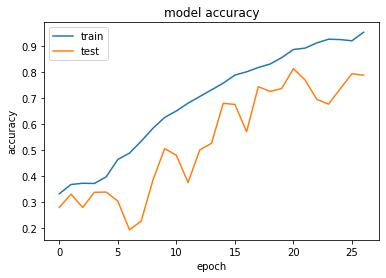

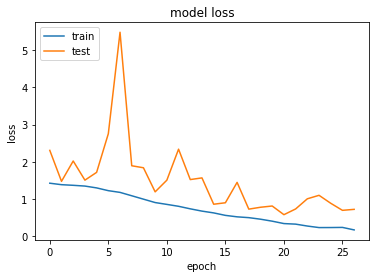

In [50]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



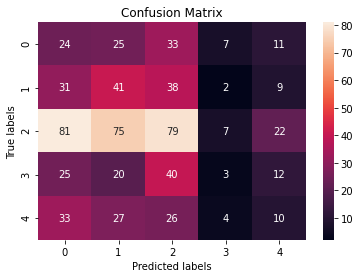

In [39]:
Y_pred = model.predict(test_ds)
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
import seaborn as sns
predicted_categories = tf.argmax(Y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
cm = confusion_matrix(true_categories,predicted_categories,labels=[0, 1, 2,3,4])

ax= plt.subplot()
sns.heatmap(cm, annot = True,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([0,1, 2,3,4]); ax.yaxis.set_ticklabels([0,1, 2,3,4]);